In [1]:
# Cell 1 (Modified)
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from dataclasses import dataclass
from IPython.display import clear_output, display
import time

@dataclass
class AttentionState:
    temporal_weight: float = 0.0
    causal_weight: float = 0.0
    novelty_weight: float = 0.0
    
    def compute_total(self) -> float:
        return (self.temporal_weight + self.causal_weight + self.novelty_weight) / 3.0

class CausalAttention:
    def __init__(self, decay_rate=0.1, novelty_threshold=0.3, memory_length=100):
        self.states: Dict[int, AttentionState] = {}
        self.history: List[Tuple[int, float]] = []
        self.decay_rate = decay_rate
        self.novelty_threshold = novelty_threshold
        self.memory_length = memory_length
    
    def update(self, neuron_id: int, prediction_error: float, current_state: float, target_state: float) -> float:
        state = self.states.get(neuron_id, AttentionState())

        # Temporal
        temporal_decay = np.exp(-self.decay_rate * len(self.history))
        state.temporal_weight = current_state * temporal_decay
        
        # Causal
        prediction_accuracy = 1.0 - min(abs(prediction_error), 1.0)
        state.causal_weight = prediction_accuracy
        
        # Novelty
        novelty = abs(target_state - current_state)
        if novelty > self.novelty_threshold:
            state.novelty_weight = novelty
        else:
            state.novelty_weight *= (1 - self.decay_rate)
        
        self.states[neuron_id] = state
        total_attention = state.compute_total()
        self.history.append((neuron_id, total_attention))
        if len(self.history) > self.memory_length:
            self.history.pop(0)
        
        return total_attention

class HebbianLayer:
    def __init__(self, input_size, output_size, eta=0.01, recurrent_eta=0.005):
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.recurrent_weights = np.random.randn(output_size, output_size) * 0.01 # Add recurrent weights
        self.eta = eta
        self.recurrent_eta = recurrent_eta
        self.last_output = np.zeros(output_size)  # Store the last output for recurrent input

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        feedforward_output = self.weights @ inputs
        recurrent_output = self.recurrent_weights @ self.last_output # Add recurrent input
        self.last_output = feedforward_output + recurrent_output # Update last_output
        return self.last_output

    def hebbian_update(self, inputs: np.ndarray, outputs: np.ndarray):
        delta_w = self.eta * np.outer(outputs, inputs)
        self.weights += delta_w
        
        # Update recurrent weights using Hebbian rule
        delta_w_recurrent = self.recurrent_eta * np.outer(outputs, self.last_output)
        self.recurrent_weights += delta_w_recurrent

class DopamineModulator:
    """
    Simple dopamine model that increases with strong input and decays over time.
    Dopamine affects the neuron's effective time constant to slow decay when high.
    """
    def __init__(self, increase_rate=0.05, decay_rate=0.01):
        self.dopamine_level = 0.0
        self.increase_rate = increase_rate
        self.decay_rate = decay_rate

    def update(self, input_strength: float):
        # Increase dopamine if input is strong (above 0.5 for example)
        if input_strength > 0.5:
            self.dopamine_level += self.increase_rate * (input_strength - 0.5)
        # Decay dopamine level
        self.dopamine_level = max(0.0, self.dopamine_level - self.decay_rate)

    def get_dopamine_modulation(self):
        # Higher dopamine -> larger effective tau (less decay)
        return 1.0 + self.dopamine_level

class WeightedLTCNeuron:
    def __init__(self, tau=1.0, num_inputs=3):
        self.state = 0.0
        self.base_tau = tau
        self.num_inputs = num_inputs
        self.weights = np.random.uniform(-0.5, 0.5, size=num_inputs)
    
    def update(self, inputs, dt=0.1, tau_mod=1.0, feedback=0.0):
        # feedback is a recurrent input from another neuron
        synaptic_input = np.dot(self.weights, inputs) + feedback
        effective_tau = self.base_tau * tau_mod
        dstate = (-self.state / effective_tau) + synaptic_input
        self.state += dstate * dt
        return self.state

class SpecializedNeuron(WeightedLTCNeuron):
    def __init__(self, tau=1.0, role="default", num_inputs=3):
        super().__init__(tau=tau, num_inputs=num_inputs)
        self.role = role

    def update(self, inputs, dt=0.1, tau_mod=1.0, feedback=0.0):
        synaptic_input = np.dot(self.weights, inputs) + feedback
        
        if self.role == "memory":
            # Slower decay baseline
            effective_tau = self.base_tau * tau_mod * 1.5
            dstate = (-self.state / effective_tau) + synaptic_input
        elif self.role == "inhibition":
            # Inhibit signals
            synaptic_input = -synaptic_input * 0.5
            effective_tau = self.base_tau * tau_mod
            dstate = (-self.state / effective_tau) + synaptic_input
        elif self.role == "amplification":
            # Amplify signals
            synaptic_input = synaptic_input * 1.5
            effective_tau = self.base_tau * tau_mod
            dstate = (-self.state / effective_tau) + synaptic_input
        else:
            # Default LTC behavior
            effective_tau = self.base_tau * tau_mod
            dstate = (-self.state / effective_tau) + synaptic_input
        
        self.state += dstate * dt
        return self.state

class LTCNeuronWithAttention:
    def __init__(self, neuron_id: int, tau: float = 1.0):
        self.id = neuron_id
        self.tau = tau
        self.state = 0.0
        self.attention = CausalAttention()
        self.last_prediction = 0.0
        
    def update(self, input_signal: float, dt: float) -> float:
        prediction_error = input_signal - self.last_prediction
        attention_value = self.attention.update(
            neuron_id=self.id,
            prediction_error=prediction_error,
            current_state=self.state,
            target_state=input_signal
        )
        effective_tau = self.tau * (1.0 - 0.3 * attention_value)
        
        d_state = (1.0/effective_tau) * ((input_signal * (1.0 + attention_value)) - self.state) * dt
        self.state += d_state
        self.last_prediction = self.state
        return self.state

In [2]:
# Cell 2 (Modified)
class AttentiveNetworkWithHebbAndRoles:
    def __init__(self, roles=None, input_size=3, eta=0.005, dopamine_increase_rate=0.05, dopamine_decay_rate=0.01, recurrent_eta=0.002): #Added recurrent_eta
        if roles is None:
            # Default roles: one memory, one inhibition, one amplification
            roles = ["memory", "inhibition", "amplification"]
        
        self.neurons = [
            SpecializedNeuron(tau=1.0+(0.2*i), role=roles[i % len(roles)], num_inputs=input_size)
            for i in range(len(roles))
        ]
        
        self.num_neurons = len(self.neurons)
        self.hebb = HebbianLayer(input_size=input_size, output_size=self.num_neurons, eta=eta, recurrent_eta=recurrent_eta) # Initialize with recurrent_eta
        self.dopamine = DopamineModulator(increase_rate=dopamine_increase_rate, decay_rate=dopamine_decay_rate)
        
        self.state_history = []
        self.input_history = []
        self.time_steps = []
        self.current_step = 0

    def update_step(self, raw_inputs: List[float], dt=0.1):
        inputs = np.array(raw_inputs)
        
        # Update dopamine based on input strength (e.g., mean of inputs)
        input_strength = np.mean(inputs)
        self.dopamine.update(input_strength)
        tau_mod = self.dopamine.get_dopamine_modulation()
        
        # Hebbian forward pass
        hebb_outputs = self.hebb.forward(inputs) # Pass the recurrent input into the Hebbian layer
        
        # Simple recurrent feedback: let's feed the last neuron's state as feedback to the first neuron
        feedback = self.neurons[-1].state * 0.1  # small feedback factor
        
        states = []
        for i, neuron in enumerate(self.neurons):
            fb = feedback if i == 0 else 0.0  # Only first neuron receives feedback from last neuron
            s = neuron.update(hebb_outputs, dt, tau_mod=tau_mod, feedback=fb)
            states.append(s)
        
        # Hebbian update
        pre_activities = inputs
        post_activities = np.array(states)
        self.hebb.hebbian_update(pre_activities, post_activities)
        
        self.state_history.append(states)
        self.input_history.append(raw_inputs)
        self.time_steps.append(self.current_step)
        self.current_step += 1
        
        return states

    def plot_results(self):
        states = np.array(self.state_history)
        inputs = np.array(self.input_history)

        fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))

        # States
        for i in range(self.num_neurons):
            ax1.plot(self.time_steps, states[:, i], label=f'Neuron {i} ({self.neurons[i].role})')
        ax1.set_title('Neuron States')
        ax1.legend()
        ax1.grid(True)

        # Inputs
        for i in range(inputs.shape[1]):
            ax2.plot(self.time_steps, inputs[:, i], label=f'Input {i}')
        ax2.set_title('Inputs')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_hebb_weights(self):
        plt.figure(figsize=(6,4))
        plt.imshow(self.hebb.weights, aspect='auto', cmap='viridis')
        plt.colorbar(label='Weight value')
        plt.xlabel('Input Units')
        plt.ylabel('Output Neurons')
        plt.title('Hebbian Weights')
        plt.show()
    
    def plot_recurrent_hebb_weights(self):
        plt.figure(figsize=(6,4))
        plt.imshow(self.hebb.recurrent_weights, aspect='auto', cmap='viridis')
        plt.colorbar(label='Recurrent Weight value')
        plt.xlabel('Output Neurons (from)')
        plt.ylabel('Output Neurons (to)')
        plt.title('Hebbian Recurrent Weights')
        plt.show()

Time Step: 0
Character: 'T' (ord=84, normalized=0.3294)
dt: 0.0004s, Dopamine Level: 0.0000, tau_mod: 1.0000
Feedback applied to first neuron: 0.0000
Input to Hebbian layer: [0.32941176470588235, 0.16470588235294117, -0.03411764705882353]
Hebbian outputs (to neurons): [ 0.005206   -0.00186759 -0.00348172]
Neuron 0 (memory): syn=-0.0015, tau=1.5000
Neuron 0 (memory): old_state=0.0000, new_state=-0.0000, dstate=-0.0015
Neuron 1 (inhibition): original syn=-0.0022, inhibited syn=0.0011, tau=1.2000
Neuron 1 (inhibition): old_state=0.0000, new_state=0.0000, dstate=0.0011
Neuron 2 (amplification): original syn=0.0015, amplified syn=0.0022, tau=1.4000
Neuron 2 (amplification): old_state=0.0000, new_state=0.0000, dstate=0.0022
Time Step: 1
Character: 'h' (ord=104, normalized=0.4078)
dt: 0.2092s, Dopamine Level: 0.0000, tau_mod: 1.0000
Feedback applied to first neuron: 0.0000
Input to Hebbian layer: [0.40784313725490196, 0.20392156862745098, -0.01843137254901961]
Hebbian outputs (to neurons): [ 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

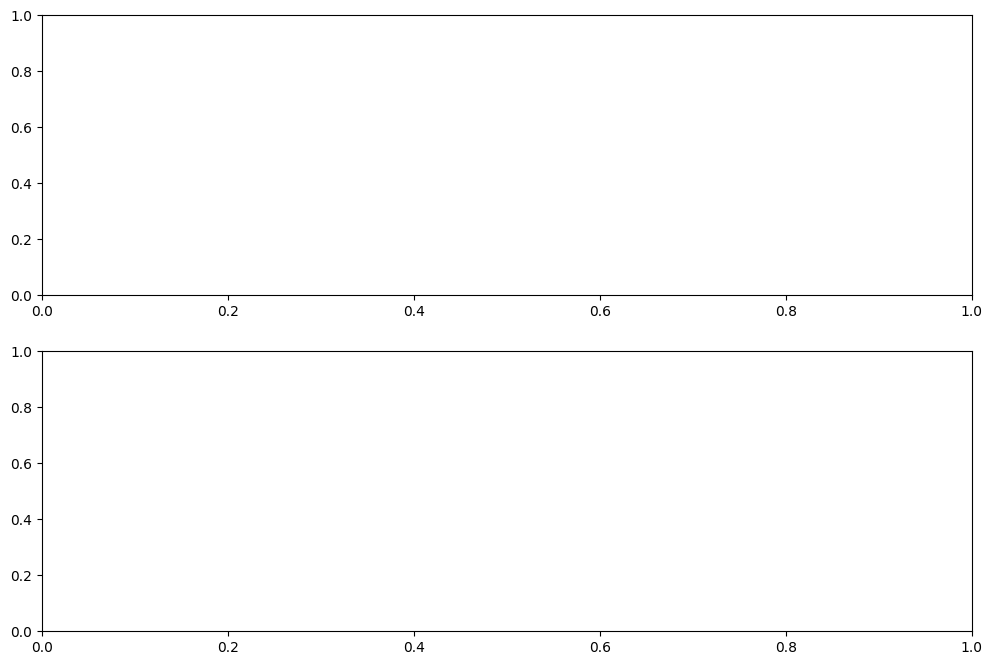

In [3]:
# Cell 3 (Modified)
# Example input stream: a sequence of characters
input_stream = list("The quick brown fox jumps")

# Initialize the updated network with roles, dopamine, and recurrence as before
network = AttentiveNetworkWithHebbAndRoles(
    roles=["memory", "inhibition", "amplification"],
    input_size=3, 
    eta=0.005,
    dopamine_increase_rate=0.05,
    dopamine_decay_rate=0.01,
    recurrent_eta=0.002 # Added recurrent_eta
)

def char_to_inputs(ch):
    val = ord(ch) / 255.0
    return [val, val/2, (val-0.5)*0.2]

states_over_time = []
time_steps = []

fig, ax = plt.subplots(figsize=(8,6))
plt.ioff()

last_time = time.time()

for t, ch in enumerate(input_stream):
    inp = char_to_inputs(ch)
    current_time = time.time()
    dt = current_time - last_time
    last_time = current_time

    # Before update, gather some internal info:
    # We'll temporarily modify AttentiveNetworkWithHebbAndRoles to store intermediate vars for logging:
    # (If you prefer not to modify the class, you can subclass or just print after calling update_step.)
    # For this example, let's assume we add a method to return debug info after calling update_step.

    # Manually replicate some logic from update_step to get intermediate steps for logging:
    input_strength = np.mean(inp)
    network.dopamine.update(input_strength)
    tau_mod = network.dopamine.get_dopamine_modulation()
    hebb_outputs = network.hebb.forward(np.array(inp))
    feedback = network.neurons[-1].state * 0.1 if network.neurons else 0.0

    # Print debugging info for this time slice
    print("="*50)
    print(f"Time Step: {t}")
    print(f"Character: '{ch}' (ord={ord(ch)}, normalized={ord(ch)/255.0:.4f})")
    print(f"dt: {dt:.4f}s, Dopamine Level: {network.dopamine.dopamine_level:.4f}, tau_mod: {tau_mod:.4f}")
    print(f"Feedback applied to first neuron: {feedback:.4f}")
    print("Input to Hebbian layer:", inp)
    print("Hebbian outputs (to neurons):", hebb_outputs)

    # Now do the actual update_step as before
    states = []
    pre_activities = np.array(inp)
    post_activities_list = []
    # We'll replicate the internal loop of update_step for logging details:
    for i, neuron in enumerate(network.neurons):
        fb = feedback if i == 0 else 0.0

        # Detailed logging for each neuron
        synaptic_input = np.dot(neuron.weights, hebb_outputs) + fb
        if neuron.role == "memory":
            effective_tau = neuron.base_tau * tau_mod * 1.5
            # memory role logic
            dstate = (-neuron.state / effective_tau) + synaptic_input
        elif neuron.role == "inhibition":
            inh_syn = -synaptic_input * 0.5
            effective_tau = neuron.base_tau * tau_mod
            dstate = (-neuron.state / effective_tau) + inh_syn
            # For logging, show transform:
            print(f"Neuron {i} ({neuron.role}): original syn={synaptic_input:.4f}, inhibited syn={inh_syn:.4f}, tau={effective_tau:.4f}")
        elif neuron.role == "amplification":
            amp_syn = synaptic_input * 1.5
            effective_tau = neuron.base_tau * tau_mod
            dstate = (-neuron.state / effective_tau) + amp_syn
            print(f"Neuron {i} ({neuron.role}): original syn={synaptic_input:.4f}, amplified syn={amp_syn:.4f}, tau={effective_tau:.4f}")
        else:
            effective_tau = neuron.base_tau * tau_mod
            dstate = (-neuron.state / effective_tau) + synaptic_input
        
        # If memory role, also log details
        if neuron.role == "memory":
            print(f"Neuron {i} ({neuron.role}): syn={synaptic_input:.4f}, tau={effective_tau:.4f}")

        # Update neuron state
        old_state = neuron.state
        neuron.state += dstate * dt
        states.append(neuron.state)
        post_activities_list.append(neuron.state)

        print(f"Neuron {i} ({neuron.role}): old_state={old_state:.4f}, new_state={neuron.state:.4f}, dstate={dstate:.4f}")

    # After updating neurons, perform Hebbian update
    post_activities = np.array(post_activities_list)
    network.hebb.hebbian_update(pre_activities, post_activities)
    
    # Record states
    states_over_time.append(states)
    time_steps.append(t)

    # Plotting as before
    #clear_output(wait=True)
    
    ax.clear()
    states_array = np.array(states_over_time)
    for i, neuron in enumerate(network.neurons):
        ax.plot(time_steps, states_array[:, i], label=f'Neuron {i} ({neuron.role})')
    
    ax.set_title(f'Neuron States Over Time (last input: "{ch}")')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('State')
    ax.grid(True)
    ax.legend()
    
    #display(fig)
    time.sleep(0.2)

plt.close(fig)
network.plot_results()
network.plot_hebb_weights()
network.plot_recurrent_hebb_weights()